In [114]:
#Implement a Dataloader read directly from the image folders

import os
import torch
import random

import torch.nn.functional as F

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [141]:
class LazyLoadDataset(Dataset):
    def __init__(self, samples, transform=None, crop_size=1024):
        self.samples = samples
        self.transform = transform
        self.crop_size = crop_size

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        surface_volume_paths, ink_label_path = self.samples[idx]

        # Generate a random crop location
        image_width, image_height = Image.open(surface_volume_paths[0]).size
        x = random.randint(0, image_width - self.crop_size)
        y = random.randint(0, image_height - self.crop_size)

        surface_volume_images = [
            self.apply_crop_and_transform(path, x, y)
            for path in surface_volume_paths
        ]
        ink_label_image = self.apply_crop_and_transform_label(ink_label_path, x, y)

        return surface_volume_images, ink_label_image

    def apply_crop_and_transform(self, image_path, x, y):
        image = Image.open(image_path).crop((x, y, x + self.crop_size, y + self.crop_size))

        if self.transform:
            image = self.transform(image)

        return image

    def apply_crop_and_transform_label(self, image_path, x, y):
        image = Image.open(image_path).crop((x, y, x + self.crop_size, y + self.crop_size))
        image = image.resize((int(self.crop_size/4),int(self.crop_size/4)))

        if self.transform:
            image = self.transform(image)

        return image


In [142]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []  # To store tuples of (surface_volume_paths, ink_label_path)

        for class_name in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                surface_volume_dir = os.path.join(class_dir, "surface_volume")
                ink_label_path = os.path.join(class_dir, "inklabels.png")
                surface_volume_paths = [os.path.join(surface_volume_dir, filename) for filename in os.listdir(surface_volume_dir)]
                self.samples.append((surface_volume_paths, ink_label_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        surface_volume_paths, ink_label_path = self.samples[idx]

        return surface_volume_paths, ink_label_path

In [143]:
# Define the root directory of your dataset
root_dir = '../../Datasets/vesuvius-challenge-ink-detection/train_frag_split'

In [174]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Create the CustomDataset
dataset = CustomDataset(root_dir)
lazy_dataset = LazyLoadDataset(dataset.samples, transform=transform, crop_size=1024)

# Create DataLoader
batch_size = 1
train_loader = DataLoader(lazy_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

In [175]:
# Get a batch of data from the DataLoader
batch = next(iter(train_loader))
surface_volume_images, ink_label_images = batch

In [176]:
surface_volume_images[0].shape

torch.Size([1, 1, 1024, 1024])

In [177]:
ink_label_images.shape

torch.Size([1, 1, 256, 256])

In [178]:
import matplotlib.pyplot as plt
import numpy as np

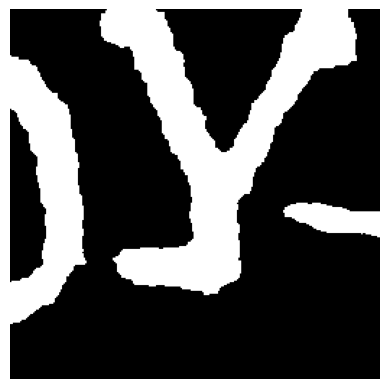

In [179]:
# Display the grayscale image
plt.imshow(ink_label_images.squeeze(0).squeeze(0), cmap="gray") #last [] is the layer
plt.axis("off")
plt.show()

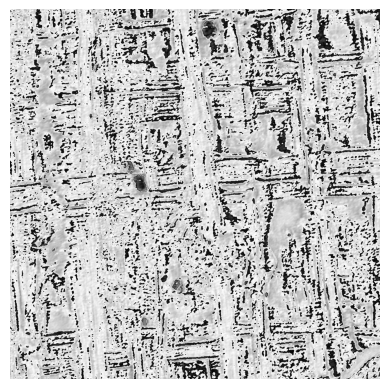

In [180]:
# Display the grayscale image
plt.imshow(surface_volume_images[5].squeeze(0).squeeze(0), cmap="gray") #last [] is the layer
plt.axis("off")
plt.show()